Work on getting an IGC that models ecostress
============================================

In [50]:
from geocal import *
from ecostress import *
import h5py
import os
import scipy
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
orb_fname = "/data/smyth/ecostress-test-data/latest/L1A_RAW_ATT_80005_20150124T204251_0100_01.h5.expected"
orb = HdfOrbit_Eci_TimeJ2000(orb_fname, "", "Ephemeris/time_j2000",
                             "Ephemeris/eci_position",
                             "Ephemeris/eci_velocity",
                             "Attitude/time_j2000",
                             "Attitude/quaternion")
rad_fname = "/data/smyth/ecostress-test-data/latest/ECOSTRESS_L1B_RAD_80005_001_20150124T204251_0100_01.h5.expected"
f = h5py.File(rad_fname, "r")
tmlist = f["/Time/line_start_time_j2000"][:]
tt = MeasuredTimeTable([Time.time_j2000(t) for t in tmlist])
datum = os.environ["AFIDS_VDEV_DATA"] + "/EGM96_20_x100.HLF"
srtm_dir = os.environ["ELEV_ROOT"]
dem = SrtmDem(srtm_dir,False, DatumGeoid96(datum))

In [3]:
# Initial camera, we will change this
cam_fname = "/data/smyth/ecostress-test-data/latest/l1_osp_dir/camera.xml"
cam_old = read_shelve(cam_fname)

In [4]:
def pixel_size(cam, ic):
    t, fc = tt.time(ic)
    od = orb.orbit_data(t)
    gp1 = od.surface_intersect(cam, fc, dem)
    fc.line = fc.line + 1
    gp2 = od.surface_intersect(cam, fc, dem)
    fc.line = fc.line - 1
    fc.sample = fc.sample + 1
    gp3 = od.surface_intersect(cam, fc, dem)
    print(distance(gp1, gp2))
    print(distance(gp1, gp3))

In [5]:
pixel_size(cam_old, ImageCoordinate(0,0))

70.38688759623848
76.768843193277


In [6]:
cam = read_shelve("camera.xml")

In [7]:
pixel_size(cam, ImageCoordinate(0,0))

39.153972143190735
40.18314730765374


In [8]:
print(cam.number_band)

6


In [9]:
32.2e-6 * 2.660 * rad_to_deg * 5400

26.500489777014444

In [10]:
173.88e-3 / 32.2e-6

5400.000000000001

In [11]:
2.66 * 1.181

3.1414600000000004

In [12]:
25.4 / 60 * 2 * pi

2.659881780039358

In [13]:
t0, fc = tt.time(ImageCoordinate(0,0))
od = orb.orbit_data(t0)

In [14]:
def od_scan(od, sa):
    '''Convert a orbit data w/o the scan mirror to one with the scan_angle (in radians)'''
    return QuaternionOrbitData(od.time, od.position_ci, od.velocity_ci, 
                               od.sc_to_ci * quat_rot_x(sa))
def scan_angle(time):
    # Not sure about this
    scan_min = -25.5 * deg_to_rad
    scan_max = 25.5 * deg_to_rad
    scan_time = 173.88e-3
    scan_rate = (scan_max - scan_min) / scan_time
    return (time - t0) * scan_rate + scan_min
    
def od_time(od, time):
    return od_scan(od, scan_angle(time))

In [15]:
gp1 = od_time(od, t0 + 5400 * 31.6e-6).surface_intersect(cam, fc, dem)
gp2 = od_time(od, t0 + 5401 * 31.6e-6).surface_intersect(cam, fc, dem)
print(distance(gp1,gp2))

80.7276609540291


In [16]:
tt = EcostressTimeTable(t0, False)

In [17]:
print(tt)

EcostressTimeTable:
  Start time:     2015-01-24T20:42:51.230216Z
  Number scan:    44
  Averaging done: False



In [18]:
t, fc = tt.time(ImageCoordinate(0,5))
print(t)
print(fc)

2015-01-24T20:42:51.230377Z
Frame Coordinate: (0, 0)


In [19]:
sm = EcostressScanMirror()
print(sm)

EcostressScanMirror:
  Scan start:     25.5 deg
  Scan end:       -25.5 deg
  Number_sample:  5400



In [20]:
igc = EcostressImageGroundConnection(orb, tt, cam, sm, dem, None)

In [21]:
print(igc)

EcostressImageGroundConnection
  Title:      
  Resolution: 30
  Band:       4
  Max height: 9000
  Orbit: 
    HdfOrbit
      File name: /data/smyth/ecostress-test-data/latest/L1A_RAW_ATT_80005_20150124T204251_0100_01.h5.expected
      Min time:      2015-01-24T20:42:51.230216Z
      Max time:      2015-01-24T20:45:37.230216Z
  Time table: 
    EcostressTimeTable:
      Start time:     2015-01-24T20:42:51.230216Z
      Number scan:    44
      Averaging done: False
  Camera: 
    EcostressCamera
        EcostressParaxialTransform
  Scan mirror: 
    EcostressScanMirror:
      Scan start:     25.5 deg
      Scan end:       -25.5 deg
      Number_sample:  5400
  Dem: 
    SRTM DEM:
      Datum:
        Geoid 96 Datum
          File: /opt/afids/data/vdev/EGM96_20_x100.HLF
      Data:
        RasterMultifile 622801 x 1296001
          Map info: Coordinate: 
            Geodetic Coordinate Converter
        ULC:       (-180, 83)
        LRC:       (180, -90.0003)
        Number:    (129600

In [22]:
g1 = igc.ground_coordinate(ImageCoordinate(0,0))
g2 = igc.ground_coordinate(ImageCoordinate(0,1))
g3 = igc.ground_coordinate(ImageCoordinate(1,0))
print(distance(g1,g2))
print(distance(g1,g3))

80.45903390315995
43.46784081992591


In [23]:
write_shelve("igc.xml", igc)

In [24]:
print(igc.ground_coordinate(ImageCoordinate(500,-40)))

Ecr: (-2.55035e+06 m, -4.13604e+06 m, 4.11994e+06 m)


In [37]:
gpt = igc.ground_coordinate(ImageCoordinate(10,10))
h = gpt.height_reference_surface
lat0 = gpt.latitude
lon0 = gpt.longitude
def func(x):
    gpt = igc.ground_coordinate_approx_height(ImageCoordinate(x[0],x[1]),h)
    return [gpt.latitude - lat0, gpt.longitude - lon0]

In [38]:
scipy.optimize.root(func, [igc.number_line / 2, igc.number_sample/2])

RuntimeError: Out of range error in file ../../ecostress-level1/lib/ecostress_time_table.cc at line 84
Value:           -352.913
Minimum allowed: 0
Maximum allowed: 11264

In [43]:
scipy.optimize.root(func, [igc.number_line / 2,10])

    fjac: array([[-0.5290771 ,  0.84857376],
       [-0.84857376, -0.5290771 ]])
     fun: array([ -3.55271368e-14,   2.84217094e-14])
 message: 'The solution converged.'
    nfev: 14
     qtf: array([  4.30222942e-11,   3.94819537e-12])
       r: array([-0.00046597, -0.00023709,  0.00083723])
  status: 1
 success: True
       x: array([ 455.16674896,   10.4532996 ])

In [44]:
print(distance(igc.ground_coordinate(ImageCoordinate(10,10)),
               igc.ground_coordinate(ImageCoordinate(455,10))))

43.25975643741675


In [78]:
smp = 0
pt = np.array([[igc.ground_coordinate(ImageCoordinate(ln, smp)).latitude, 
  igc.ground_coordinate(ImageCoordinate(ln, smp)).longitude] for ln in range(0,igc.number_line,10)])
orb_pt = np.array([[igc.orbit_data(igc.time_table.time(ImageCoordinate(i,smp))[0], smp).position_cf.latitude,
                   igc.orbit_data(igc.time_table.time(ImageCoordinate(i,smp))[0], smp).position_cf.longitude]
                  for i in range(0,igc.number_line, 10)])
smp = igc.number_sample
pt2 = np.array([[igc.ground_coordinate(ImageCoordinate(ln, smp)).latitude, 
  igc.ground_coordinate(ImageCoordinate(ln, smp)).longitude] for ln in range(0,igc.number_line,10)])

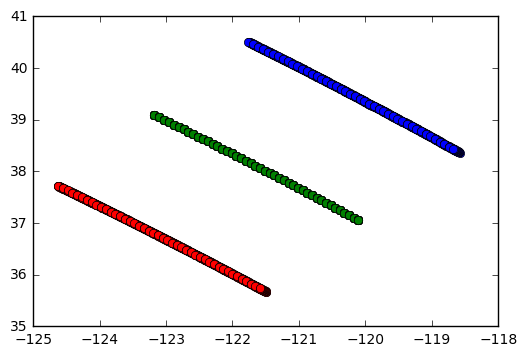

In [81]:
plt.plot(pt[:,1],pt[:,0],'o', orb_pt[:,1], orb_pt[:,0], 'o', pt2[:,1],pt2[:,0],'o')

In [70]:
print(Geodetic(igc.ground_coordinate(ImageCoordinate(10,10))))
print(Geodetic(igc.ground_coordinate(ImageCoordinate(455,10))))

Geodetic: (40.4428 deg, -121.673 deg, 1454.28 m)
Geodetic: (40.4431 deg, -121.673 deg, 1447.52 m)


In [74]:
for i in range(0,igc.number_line,10):
    print(i, ":", Geodetic(igc.ground_coordinate(ImageCoordinate(i,10))))
    tm, fc = igc.time_table.time(ImageCoordinate(i,10))
    print(Geodetic(igc.orbit_data(tm, 10).position_cf))

0 : Geodetic: (40.4402 deg, -121.669 deg, 1478.66 m)
Geodetic: (39.0932 deg, -123.174 deg, 413195 m)
10 : Geodetic: (40.4428 deg, -121.673 deg, 1454.28 m)
Geodetic: (39.0932 deg, -123.174 deg, 413195 m)
20 : Geodetic: (40.4455 deg, -121.677 deg, 1415.98 m)
Geodetic: (39.0932 deg, -123.174 deg, 413195 m)
30 : Geodetic: (40.4482 deg, -121.681 deg, 1382.49 m)
Geodetic: (39.0932 deg, -123.174 deg, 413195 m)
40 : Geodetic: (40.4508 deg, -121.684 deg, 1348.57 m)
Geodetic: (39.0932 deg, -123.174 deg, 413195 m)
50 : Geodetic: (40.4535 deg, -121.688 deg, 1305.76 m)
Geodetic: (39.0932 deg, -123.174 deg, 413195 m)
60 : Geodetic: (40.4561 deg, -121.692 deg, 1302.86 m)
Geodetic: (39.0932 deg, -123.174 deg, 413195 m)
70 : Geodetic: (40.4586 deg, -121.696 deg, 1295.38 m)
Geodetic: (39.0932 deg, -123.174 deg, 413195 m)
80 : Geodetic: (40.4612 deg, -121.7 deg, 1289.37 m)
Geodetic: (39.0932 deg, -123.174 deg, 413195 m)
90 : Geodetic: (40.4638 deg, -121.703 deg, 1279.38 m)
Geodetic: (39.0932 deg, -123.17